# Введение

_____
    
**Название проекта**

TODO: переделать


Пневмония на ретген снимках

_____
**Цель исследования.**
    
Создание модели прогнозирования — для классификации рентгеновских снимков грудной клетки, на здоровые (Normal) и имеющие пневмонию (Pneumonia)
    
_____
**Задачи исследования.**

1. Загрузка данных.
2. Разбивка данных на df_test и df_valid.
3. Применение аугментаций к изображениям.
4. Расчет class_weight.
5. Создание и тренировка модели.
6. Проверка модели на df_test.
7. Отображение матрицы корреляции.
8. Отображение изображений с ошибочными предсказаниями.
_____

# Загрузка данных

## Импорт библиотек

___
    Импортируем все необходимые нам библиотеки
    И установим константные переменные
___

In [1]:
%pip install matplotlib -q
%pip install kagglehub -q
%pip install tensorflow -q
%pip install seaborn -q
%pip install ipywidgets -q
%pip install opencv-python -q
%pip install scikit-learn -q
%pip install tf-keras -q
%pip install segmentation-models -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Стандартные библиотеки
import math
import random
from pathlib import Path

# Библиотеки для работы с данными и визуализации
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Основные библиотеки для глубокого обучения
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Библиотека для моделей сегментации
import segmentation_models as sm



# Настройки для воспроизводимости
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Параметры данных и модели
IMG_SIZE = 256
N_CHANNELS = 3
BATCH_SIZE = 8  

# Пути к данным
BASE_DIR = Path('data')
IMAGE_DIR = BASE_DIR / 'images'
LABEL_DIR = BASE_DIR / 'labels'

# Настройки для визуализаций
plt.rcParams['axes.titlesize'] = 21

2025-09-07 12:38:28.703413: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-07 12:38:29.531424: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-07 12:38:31.172655: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Segmentation Models: using `tf.keras` framework.


## Сопоставление данных

___
    Сопоставим изображения и разметку
___

In [3]:
# напишем функцию для сопоставления
def get_file_map(image_dir, label_dir):
    file_map = {}
    
    # получим изображение
    for image_path in image_dir.glob('*.jpg'):
        file_stem = image_path.stem
        file_map[file_stem] = {'image': str(image_path)}

    # получим для изображения метки
    for label_path in label_dir.glob('*.txt'):
        file_stem = label_path.stem
        if file_stem in file_map:
            file_map[file_stem]['label'] = str(label_path)

    # сохраним пару     
    paired_files = [
        (data['image'], data['label']) for key, data in file_map.items()
    ]
            
    return paired_files

In [14]:
file_pairs = get_file_map(IMAGE_DIR, LABEL_DIR)

print(f"Найдено {len(file_pairs)} пар изображение-разметка.")

Найдено 1141 пар изображение-разметка.


# Анализ данных

---

Напишем функцию для создания маски из координат

Затем визуализируем изображение - маску - контур

---

In [ ]:
# напишем функцию получения маски из координат
def polygons_to_mask(label_path, height, width):
    mask = np.zeros((height, width), dtype=np.uint8)
    if not Path(label_path).exists():
        return mask
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            coords_normalized = np.array(parts[1:], dtype=np.float32)
            coords = coords_normalized.reshape(-1, 2)
            coords[:, 0] *= width
            coords[:, 1] *= height
            pts = coords.astype(np.int32)
            cv2.fillPoly(mask, [pts], color=(255))
    return mask

In [4]:
def visualize_random_sample(file_pairs):
    for i in range(3):
        # выберем случайное изображение
        image_path, label_path = random.choice(file_pairs)

        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width, _ = image_rgb.shape
        
        # создадим маску
        mask = polygons_to_mask(label_path, height, width)
        overlay = image_rgb.copy()
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        cv2.drawContours(overlay, contours, -1, (255, 0, 0), 2) # Красные контуры толщиной 2 пикселя
        
        # выведем изображение
        fig, axes = plt.subplots(1, 3, figsize=(24, 8))
        
        axes[0].imshow(image_rgb)
        axes[0].set_title("Оригинальное изображение")
        axes[0].axis('off')
        
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title("Сгенерированная маска")
        axes[1].axis('off')
        
        axes[2].imshow(overlay)
        axes[2].set_title("Изображение с контуром")
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()

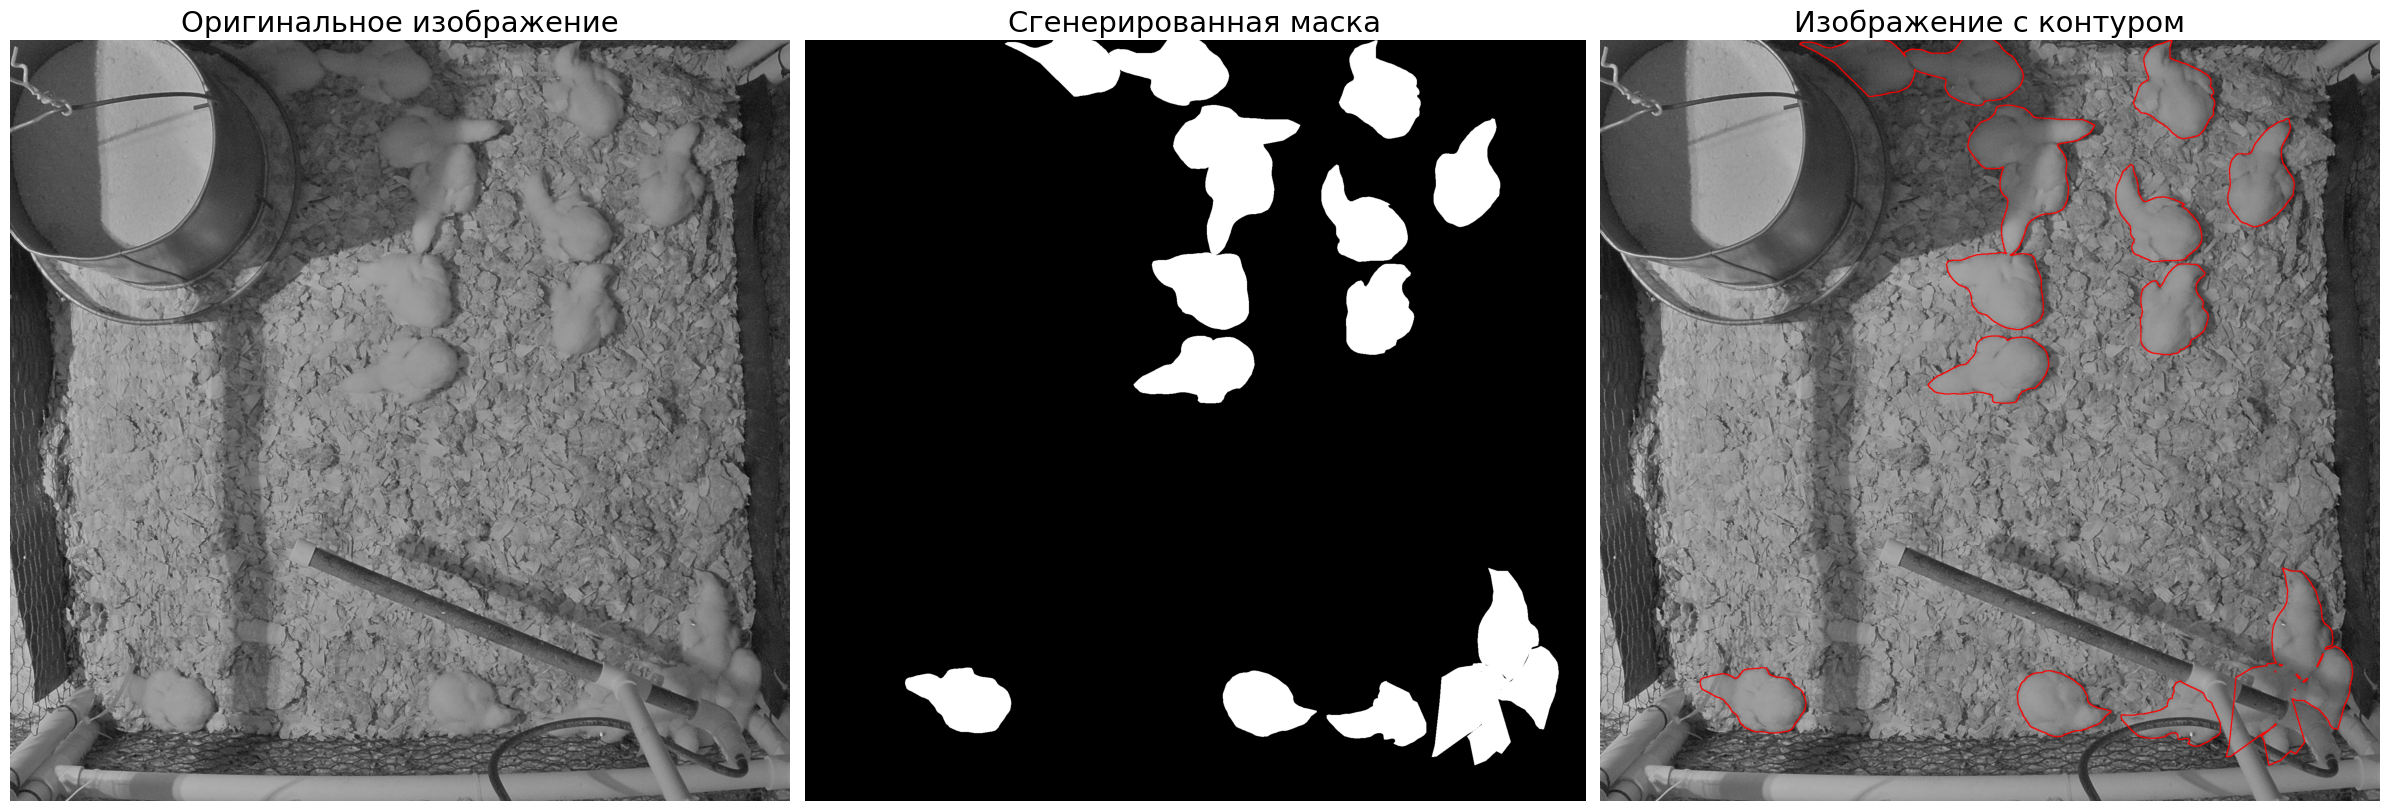

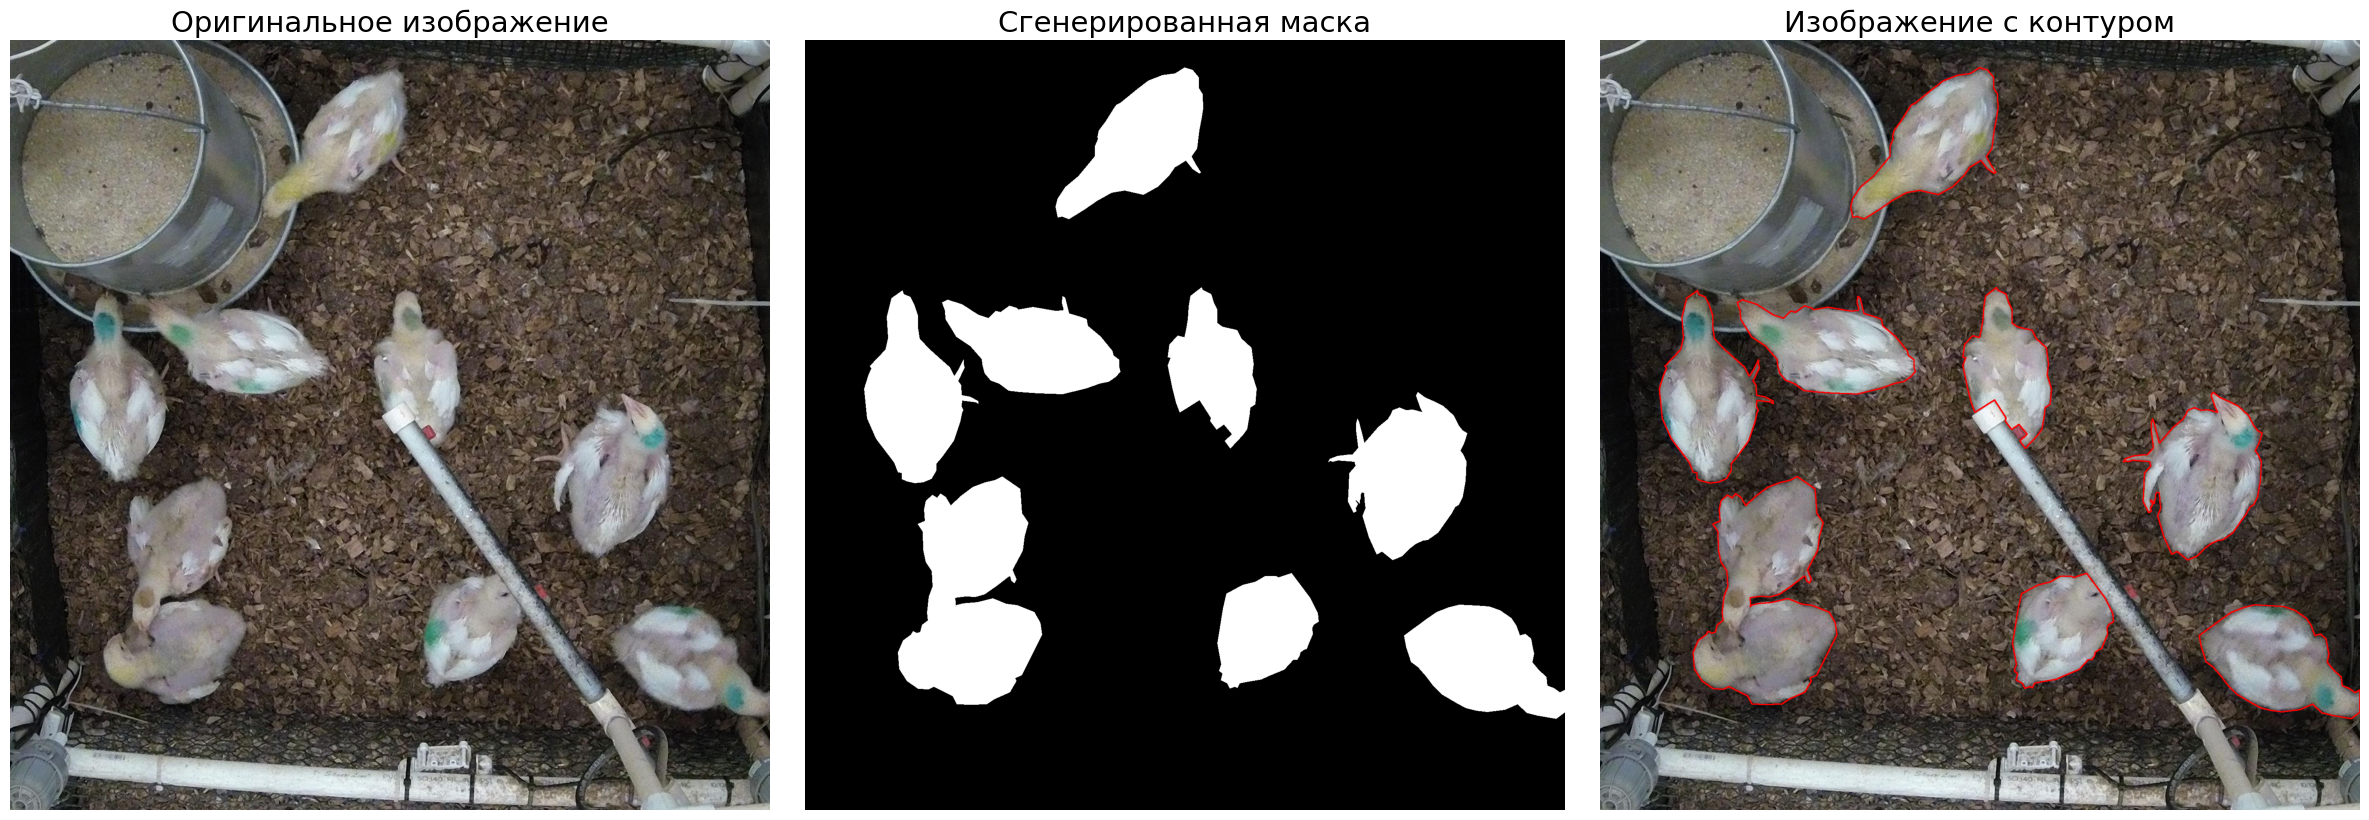

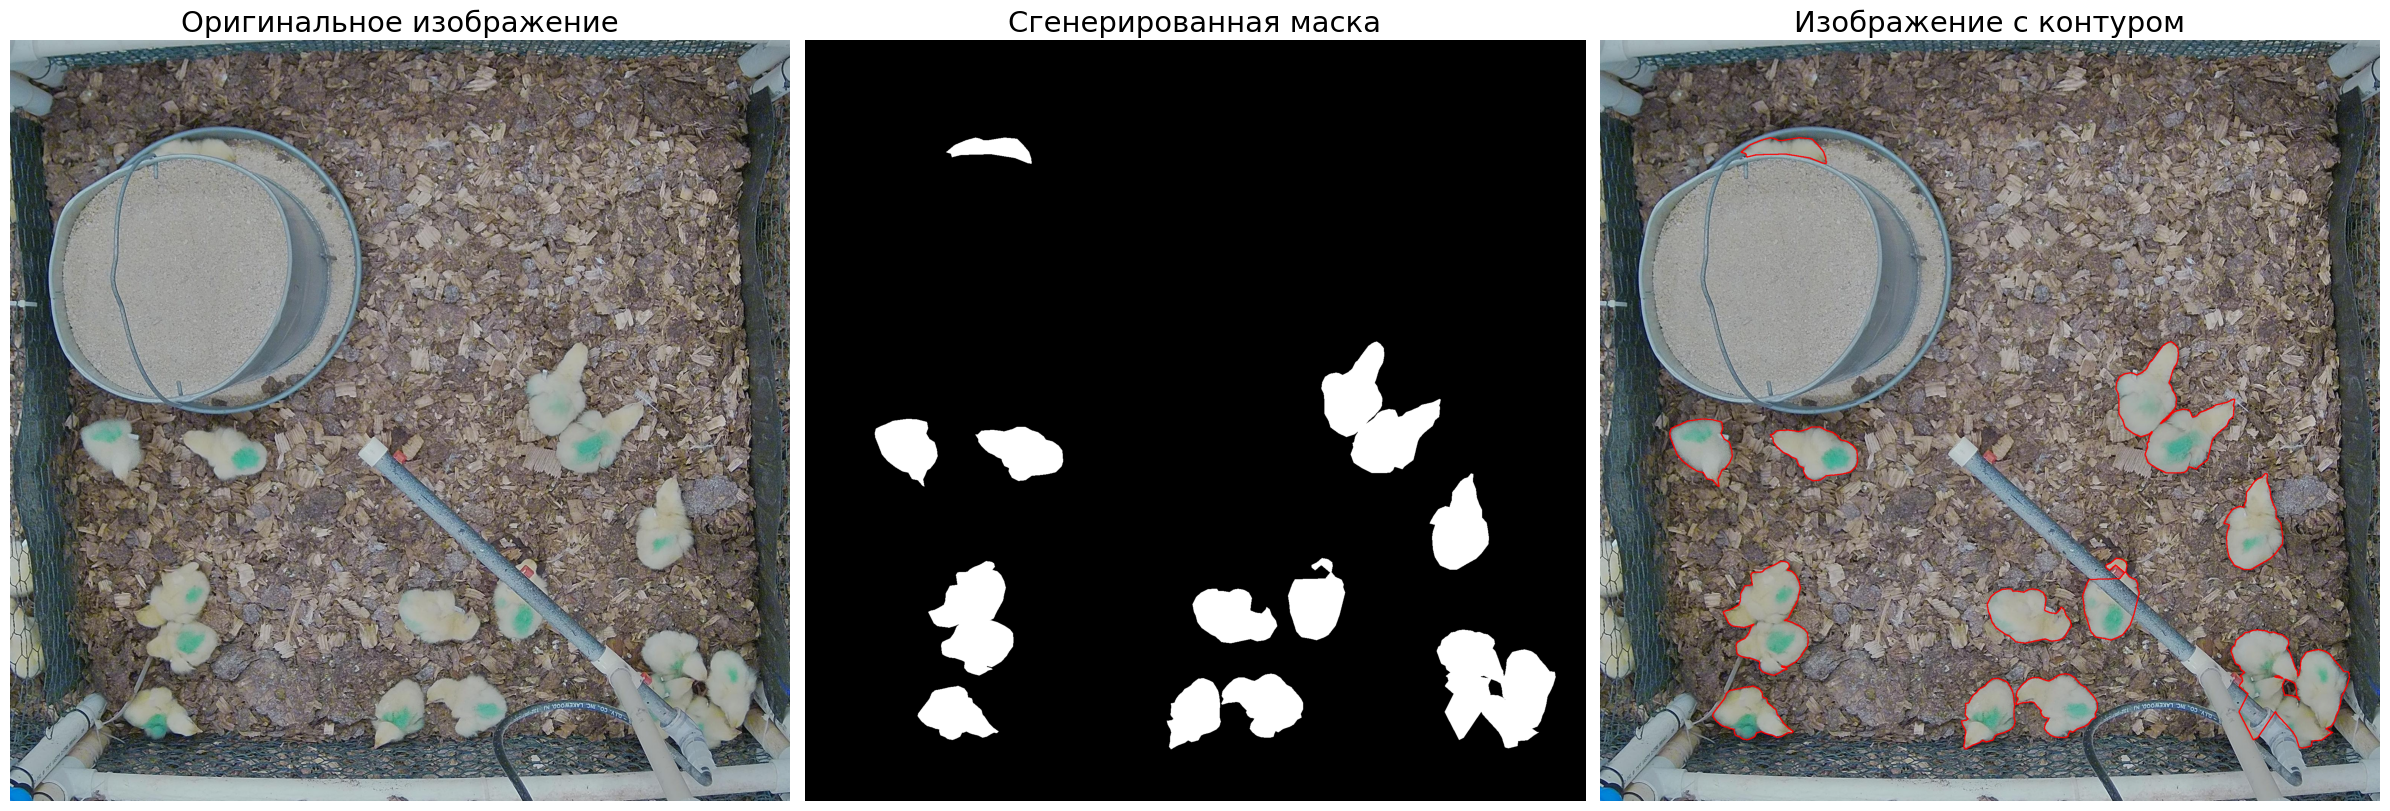

In [8]:
visualize_random_sample(file_pairs)

# Предподготовка

In [8]:
def data_generator(file_pairs):
    """
    Python-генератор, который загружает изображение и маску,
    изменяет их размер и возвращает.
    """
    for img_path, mask_path in file_pairs:
        # Загружаем изображение
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Загружаем маску
        h, w, _ = image.shape
        mask = polygons_to_mask(mask_path, h, w)
        
        # Изменяем размер
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        
        # Нормализуем значения
        image = image / 255.0
        mask = mask / 255.0 # Маска будет состоять из 0.0 и 1.0
        
        # Добавляем канальное измерение для маски (H, W) -> (H, W, 1)
        mask = np.expand_dims(mask, axis=-1)
        
        yield image, mask


In [9]:
train_files, val_files = train_test_split(file_pairs, test_size=0.2, random_state=42)


# 1. Сначала отделяем 20% данных под валидацию и тест
train_files, val_test_files = train_test_split(file_pairs, test_size=0.2, random_state=RANDOM_SEED)

# 2. Затем делим эти 20% пополам (50/50), чтобы получить 10% на валидацию и 10% на тест
val_files, test_files = train_test_split(val_test_files, test_size=0.5, random_state=RANDOM_SEED)

print(f"Общее количество примеров: {len(file_pairs)}")
print(f"Количество для обучения (train): {len(train_files)}")
print(f"Количество для валидации (validation): {len(val_files)}")
print(f"Количество для теста (test): {len(test_files)}")

Общее количество примеров: 1141
Количество для обучения (train): 912
Количество для валидации (validation): 114
Количество для теста (test): 115


In [10]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_files),
    output_signature=(
        tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, N_CHANNELS), dtype=tf.float32),
        tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_files),
    output_signature=(
        tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, N_CHANNELS), dtype=tf.float32),
        tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32)
    )
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(test_files),
    output_signature=(
        tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, N_CHANNELS), dtype=tf.float32),
        tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32)
    )
)

I0000 00:00:1757228054.016687  298595 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5527 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [11]:
print("Обучающий датасет создан:", train_dataset)
print("Валидационный датасет создан:", val_dataset)
print("Тестовый датасет создан:", test_dataset)

Обучающий датасет создан: <_FlatMapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None))>
Валидационный датасет создан: <_FlatMapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None))>
Тестовый датасет создан: <_FlatMapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None))>


## Аугментация

In [12]:
def augment(image, mask):
    # Объединяем изображение и маску, чтобы применить одно и то же преобразование
    # Убедимся, что у изображения и маски тип данных float32
    image = tf.cast(image, tf.float32)
    mask = tf.cast(mask, tf.float32)
    
    # Случайное отражение слева направо
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Случайное отражение сверху вниз
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Можно добавить и другие аугментации, например, яркость (применяется только к фото)
    image = tf.image.random_brightness(image, max_delta=0.1)
    
    return image, mask

## Pipeline

In [13]:
BATCH_SIZE = 8 # Начнем с небольшого батча, т.к. сегментационные модели требуют больше памяти

# Создаем финальные пайплайны
# AUTOTUNE позволяет tf автоматически подбирать оптимальные параметры
AUTOTUNE = tf.data.AUTOTUNE

train_batches = (
    train_dataset
    .cache()  # Кэшируем данные после первой загрузки для скорости
    .shuffle(len(train_files))
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
    .repeat()
)

val_batches = (
    val_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

test_batches = (
    test_dataset
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [14]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        # Для отображения картинки убираем batch-измерение
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# Возьмем один батч из обучающего загрузчика
for images, masks in train_batches.take(1):
    sample_image, sample_mask = images[0], masks[0]
    print("Размер тензора изображения:", sample_image.shape)
    print("Размер тензора маски:", sample_mask.shape)
    # display([sample_image, sample_mask])

2025-09-07 09:54:25.183576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 735 of 912


Размер тензора изображения: (256, 256, 3)
Размер тензора маски: (256, 256, 1)


2025-09-07 09:54:27.624330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-09-07 09:54:27.660801: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Разработка модели

## Модель U-Net

In [15]:
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.metrics import MeanIoU

def conv_block(inputs, num_filters):
    """Сверточный блок: Conv -> BN -> ReLU -> Conv -> BN -> ReLU"""
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return x

def encoder_block(inputs, num_filters):
    """Блок энкодера: Сверточный блок + Max Pooling"""
    skip = conv_block(inputs, num_filters)
    pool = layers.MaxPool2D(2)(skip)
    return skip, pool

def decoder_block(inputs, skip_features, num_filters):
    """Блок декодера: Upsampling -> Concatenate -> Сверточный блок"""
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    """Сборка ОБЛЕГЧЕННОЙ U-Net модели с Dropout"""
    inputs = Input(input_shape)

    # Энкодер (фильтры 32 -> 64 -> 128 -> 256)
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    p3 = layers.Dropout(0.2)(p3) # Добавляем Dropout
    s4, p4 = encoder_block(p3, 256)
    p4 = layers.Dropout(0.3)(p4) # Добавляем Dropout

    # "Дно"
    b1 = conv_block(p4, 512)
    b1 = layers.Dropout(0.3)(b1)

    # Декодер
    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    
    model = Model(inputs, outputs, name="Light-U-Net")
    return model

# Создаем модель
input_shape = (IMG_SIZE, IMG_SIZE, N_CHANNELS)
model_U = build_unet(input_shape)
# model_U.summary()

In [16]:
import tensorflow.keras.backend as K

# Функция Dice Loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice_coeff = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - dice_coeff

# Комбинированная функция потерь
def dice_bce_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

## Модель U-Net с предобученным энкодером 

In [17]:

# Создаем модель U-Net. Здесь код не меняется.
model_U_pre_trained = sm.Unet(
    'resnet34', 
    input_shape=(IMG_SIZE, IMG_SIZE, N_CHANNELS),
    classes=1, 
    activation='sigmoid',
    encoder_weights='imagenet'
)


# Обучение модели

In [18]:
num_model = 2
callback_monitor = 'val_mean_iou'

if num_model == 1: # Модель U-Net 
    callback_monitor = 'val_mean_iou'
    model = model_U
    iou_metric = MeanIoU(num_classes=2, name="mean_iou")
elif num_model == 2: # Модель U-Net с предобученным энкодером 
    callback_monitor = 'val_iou_score'
    model = model_U_pre_trained
    iou_metric = sm.metrics.iou_score

model.compile(
    optimizer='adam',
    loss=dice_bce_loss,
    # loss='binary_crossentropy',
    metrics=['accuracy', iou_metric]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 256, 256,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 128, 128,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 128, 128,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 64, 64,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 64, 64,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 64, 64,    │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 64, 64,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 64, 64,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 64, 64,    │      4,096 │ stage1_unit1_rel

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Путь для сохранения лучшей модели
checkpoint_path = "unet_chicken_best_model.h5"

# 1. ModelCheckpoint будет следить за нашей главной метрикой - val_mean_iou
#    и сохранять модель, когда она максимальна (mode='max').
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor=callback_monitor, 
    save_best_only=True,
    mode='max',
    verbose=1
)

# 2. EarlyStopping также будет следить за val_mean_iou. Если в течение 5 эпох
#    улучшения не будет, обучение остановится.
#    restore_best_weights=True вернет в модель веса из лучшей эпохи.
early_stopping = EarlyStopping(
    monitor=callback_monitor,
    patience=10,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

# 3. ReduceLROnPlateau будет снижать скорость обучения в 5 раз (factor=0.2),
#    если val_mean_iou не улучшается 3 эпохи.
reduce_lr = ReduceLROnPlateau(
    monitor=callback_monitor,
    factor=0.2,
    patience=3,
    mode='max',
    min_lr=1e-6,
    verbose=1
)

# Собираем все коллбэки в один список
callbacks = [model_checkpoint, early_stopping, reduce_lr]

In [20]:
import math

# Количество обучающих примеров
num_train_examples = len(train_files)
# Количество валидационных примеров
num_val_examples = len(val_files)

# Рассчитываем шаги для обучения и валидации
# Используем math.ceil для округления вверх
steps_per_epoch = math.ceil(num_train_examples / BATCH_SIZE)
validation_steps = math.ceil(num_val_examples / BATCH_SIZE)

print(f"Количество обучающих примеров: {num_train_examples}")
print(f"Количество валидационных примеров: {num_val_examples}")
print(f"Размер батча: {BATCH_SIZE}")
print(f"Шагов на эпоху (steps_per_epoch): {steps_per_epoch}")
print(f"Шагов на валидацию (validation_steps): {validation_steps}")

Количество обучающих примеров: 912
Количество валидационных примеров: 114
Размер батча: 8
Шагов на эпоху (steps_per_epoch): 114
Шагов на валидацию (validation_steps): 15


In [21]:
EPOCHS = 30 # Задаем максимальное количество эпох, EarlyStopping может остановить раньше

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch, # <--- ДОБАВИЛИ ЭТО
    validation_data=val_batches,
    validation_steps=validation_steps, # <--- И ЭТО
    callbacks=callbacks
)

Epoch 1/30


2025-09-07 09:54:42.157797: I external/local_xla/xla/service/service.cc:163] XLA service 0x759d18003b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-07 09:54:42.157838: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-09-07 09:54:42.608129: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-07 09:54:44.752887: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300


  2/114 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.4815 - iou_score: 0.2569 - loss: 1.4182    

I0000 00:00:1757228102.568505  298846 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8700 - iou_score: 0.5014 - loss: 0.7064
Epoch 1: val_iou_score improved from None to 0.25010, saving model to unet_chicken_best_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 50s 145ms/step - accuracy: 0.9292 - iou_score: 0.6506 - loss: 0.4379 - val_accuracy: 0.2514 - val_iou_score: 0.2501 - val_loss: 490.1533 - learning_rate: 0.0010
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9613 - iou_score: 0.8192 - loss: 0.2098
Epoch 2: val_iou_score did not improve from 0.25010
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.9630 - iou_score: 0.8289 - loss: 0.1983 - val_accuracy: 0.7395 - val_iou_score: 0.0148 - val_loss: 2.2275 - learning_rate: 0.0010
Epoch 3/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9701 - iou_score: 0.8575 - loss: 0.1594
Epoch 3: val_iou_score did not improve from 0.25010
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.9702 - iou_score: 0.8643 - loss: 0.1561 - val_accuracy: 0.7309 - val_iou_score: 0.1359 - val_loss: 1.8566 - learning_rate: 0.0010
Epoch 4/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9737 - iou_score: 0.8735 - loss: 0.1408
Epoch 4: va

114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.9810 - iou_score: 0.9174 - loss: 0.0928 - val_accuracy: 0.9125 - val_iou_score: 0.6773 - val_loss: 0.5145 - learning_rate: 4.0000e-05
Epoch 9/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9813 - iou_score: 0.9162 - loss: 0.0927
Epoch 9: val_iou_score improved from 0.67727 to 0.85334, saving model to unet_chicken_best_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.9812 - iou_score: 0.9173 - loss: 0.0921 - val_accuracy: 0.9650 - val_iou_score: 0.8533 - val_loss: 0.1837 - learning_rate: 4.0000e-05
Epoch 10/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9812 - iou_score: 0.9207 - loss: 0.0913
Epoch 10: val_iou_score improved from 0.85334 to 0.89717, saving model to unet_chicken_best_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.9813 - iou_score: 0.9191 - loss: 0.0909 - val_accuracy: 0.9756 - val_iou_score: 0.8972 - val_loss: 0.1303 - learning_rate: 4.0000e-05
Epoch 11/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9813 - iou_score: 0.9180 - loss: 0.0917
Epoch 11: val_iou_score improved from 0.89717 to 0.90460, saving model to unet_chicken_best_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.9814 - iou_score: 0.9187 - loss: 0.0909 - val_accuracy: 0.9771 - val_iou_score: 0.9046 - val_loss: 0.1229 - learning_rate: 4.0000e-05
Epoch 12/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9811 - iou_score: 0.9170 - loss: 0.0951
Epoch 12: val_iou_score improved from 0.90460 to 0.90634, saving model to unet_chicken_best_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.9815 - iou_score: 0.9199 - loss: 0.0899 - val_accuracy: 0.9774 - val_iou_score: 0.9063 - val_loss: 0.1211 - learning_rate: 4.0000e-05
Epoch 13/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9816 - iou_score: 0.9197 - loss: 0.0896
Epoch 13: val_iou_score improved from 0.90634 to 0.90711, saving model to unet_chicken_best_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.9816 - iou_score: 0.9211 - loss: 0.0889 - val_accuracy: 0.9775 - val_iou_score: 0.9071 - val_loss: 0.1209 - learning_rate: 4.0000e-05
Epoch 14/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9820 - iou_score: 0.9216 - loss: 0.0866
Epoch 14: val_iou_score did not improve from 0.90711
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.9818 - iou_score: 0.9215 - loss: 0.0877 - val_accuracy: 0.9776 - val_iou_score: 0.9069 - val_loss: 0.1201 - learning_rate: 4.0000e-05
Epoch 15/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9820 - iou_score: 0.9216 - loss: 0.0874
Epoch 15: val_iou_score did not improve from 0.90711
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.9818 - iou_score: 0.9215 - loss: 0.0881 - val_accuracy: 0.9776 - val_iou_score: 0.9070 - val_loss: 0.1198 - learning_rate: 4.0000e-05
Epoch 16/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9815 - iou_score: 0.9218 - loss: 0.0

114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.9820 - iou_score: 0.9225 - loss: 0.0869 - val_accuracy: 0.9777 - val_iou_score: 0.9084 - val_loss: 0.1200 - learning_rate: 4.0000e-05
Epoch 17/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9820 - iou_score: 0.9219 - loss: 0.0875
Epoch 17: val_iou_score improved from 0.90841 to 0.90880, saving model to unet_chicken_best_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.9821 - iou_score: 0.9235 - loss: 0.0861 - val_accuracy: 0.9777 - val_iou_score: 0.9088 - val_loss: 0.1192 - learning_rate: 4.0000e-05
Epoch 18/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9816 - iou_score: 0.9233 - loss: 0.0888
Epoch 18: val_iou_score improved from 0.90880 to 0.90943, saving model to unet_chicken_best_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.9821 - iou_score: 0.9234 - loss: 0.0859 - val_accuracy: 0.9778 - val_iou_score: 0.9094 - val_loss: 0.1197 - learning_rate: 4.0000e-05
Epoch 19/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9816 - iou_score: 0.9221 - loss: 0.0887
Epoch 19: val_iou_score did not improve from 0.90943
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.9822 - iou_score: 0.9246 - loss: 0.0846 - val_accuracy: 0.9778 - val_iou_score: 0.9093 - val_loss: 0.1189 - learning_rate: 4.0000e-05
Epoch 20/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9818 - iou_score: 0.9246 - loss: 0.0866
Epoch 20: val_iou_score improved from 0.90943 to 0.90965, saving model to unet_chicken_best_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.9823 - iou_score: 0.9236 - loss: 0.0855 - val_accuracy: 0.9779 - val_iou_score: 0.9097 - val_loss: 0.1187 - learning_rate: 4.0000e-05
Epoch 21/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9822 - iou_score: 0.9262 - loss: 0.0834
Epoch 21: val_iou_score improved from 0.90965 to 0.90966, saving model to unet_chicken_best_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.9824 - iou_score: 0.9253 - loss: 0.0839 - val_accuracy: 0.9780 - val_iou_score: 0.9097 - val_loss: 0.1177 - learning_rate: 4.0000e-05
Epoch 22/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9828 - iou_score: 0.9249 - loss: 0.0821
Epoch 22: val_iou_score improved from 0.90966 to 0.91067, saving model to unet_chicken_best_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.9824 - iou_score: 0.9256 - loss: 0.0831 - val_accuracy: 0.9781 - val_iou_score: 0.9107 - val_loss: 0.1177 - learning_rate: 4.0000e-05
Epoch 23/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9826 - iou_score: 0.9245 - loss: 0.0851
Epoch 23: val_iou_score did not improve from 0.91067
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.9826 - iou_score: 0.9257 - loss: 0.0830 - val_accuracy: 0.9782 - val_iou_score: 0.9101 - val_loss: 0.1170 - learning_rate: 4.0000e-05
Epoch 24/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9825 - iou_score: 0.9276 - loss: 0.0821
Epoch 24: val_iou_score improved from 0.91067 to 0.91111, saving model to unet_chicken_best_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.9827 - iou_score: 0.9260 - loss: 0.0832 - val_accuracy: 0.9782 - val_iou_score: 0.9111 - val_loss: 0.1173 - learning_rate: 4.0000e-05
Epoch 25/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9827 - iou_score: 0.9266 - loss: 0.0820
Epoch 25: val_iou_score improved from 0.91111 to 0.91187, saving model to unet_chicken_best_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 0.9827 - iou_score: 0.9265 - loss: 0.0821 - val_accuracy: 0.9783 - val_iou_score: 0.9119 - val_loss: 0.1170 - learning_rate: 4.0000e-05
Epoch 26/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9831 - iou_score: 0.9271 - loss: 0.0807
Epoch 26: val_iou_score improved from 0.91187 to 0.91213, saving model to unet_chicken_best_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.9828 - iou_score: 0.9268 - loss: 0.0817 - val_accuracy: 0.9783 - val_iou_score: 0.9121 - val_loss: 0.1167 - learning_rate: 4.0000e-05
Epoch 27/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9827 - iou_score: 0.9272 - loss: 0.0822
Epoch 27: val_iou_score improved from 0.91213 to 0.91236, saving model to unet_chicken_best_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.9829 - iou_score: 0.9275 - loss: 0.0808 - val_accuracy: 0.9783 - val_iou_score: 0.9124 - val_loss: 0.1168 - learning_rate: 4.0000e-05
Epoch 28/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9830 - iou_score: 0.9282 - loss: 0.0807
Epoch 28: val_iou_score did not improve from 0.91236
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.9830 - iou_score: 0.9281 - loss: 0.0804 - val_accuracy: 0.9784 - val_iou_score: 0.9122 - val_loss: 0.1165 - learning_rate: 4.0000e-05
Epoch 29/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9831 - iou_score: 0.9290 - loss: 0.0792
Epoch 29: val_iou_score did not improve from 0.91236
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.9831 - iou_score: 0.9282 - loss: 0.0801 - val_accuracy: 0.9786 - val_iou_score: 0.9123 - val_loss: 0.1152 - learning_rate: 4.0000e-05
Epoch 30/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9837 - iou_score: 0.9315 - loss: 0.0

114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.9832 - iou_score: 0.9293 - loss: 0.0789 - val_accuracy: 0.9785 - val_iou_score: 0.9133 - val_loss: 0.1161 - learning_rate: 4.0000e-05
Restoring model weights from the end of the best epoch: 30.


# Анализ результатов

In [31]:
def plot_history(history):
    """Строит графики обучения: loss и mean_iou."""

    if 'iou_score' in history.history:
        iou_key = 'iou_score'
    elif 'mean_iou' in history.history:
        iou_key = 'mean_iou'
    val_iou_key = 'val_' + iou_key

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    iou = history.history[iou_key]
    val_iou = history.history[val_iou_key]
    
    epochs_range = range(len(loss))

    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, iou, label='Training Mean IoU')
    plt.plot(epochs_range, val_iou, label='Validation Mean IoU')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')

    plt.show()

# plot_history(history)

In [30]:
print("--- Финальная оценка на тестовой выборке (данные, которые модель никогда не видела) ---")

# Загружаем лучшую модель, сохраненную во время обучения
best_model = tf.keras.models.load_model(
    checkpoint_path, 
    custom_objects={
        'dice_bce_loss': dice_bce_loss,
        'iou_score': sm.metrics.iou_score 
    }
)

# Оцениваем модель на тестовых данных
results = best_model.evaluate(test_batches)

print("\nРезультаты на тестовой выборке:")
print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")
print(f"IoU Score: {results[2]:.4f}")

--- Финальная оценка на тестовой выборке (данные, которые модель никогда не видела) ---


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9846 - iou_score: 0.9321 - loss: 0.0715

Результаты на тестовой выборке:
Loss: 0.0715
Accuracy: 0.9846
IoU Score: 0.9321


2025-09-07 10:12:27.830598: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-09-07 10:12:27.830636: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13131113620207053218
2025-09-07 10:12:27.830661: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13054306058002222704


In [ ]:
def show_predictions_with_contours(dataset, num_examples=3):
    """
    Показывает предсказания модели, рисуя контуры на оригинальных изображениях.
    """
    print("\nПримеры предсказаний на валидационных данных:")
    
    for images, masks in dataset.take(num_examples):
        # Делаем предсказание для всего батча
        pred_masks = model.predict(images)

        # Проходимся по каждому примеру в батче
        for i in range(len(images)):
            # --- Преобразуем тензоры в numpy-массивы для OpenCV ---
            # Оригинальное изображение
            original_image = (images[i].numpy() * 255).astype(np.uint8)
            
            # Реальная маска (Ground Truth)
            true_mask = (masks[i].numpy() * 255).astype(np.uint8)
            
            # Предсказанная маска. Применяем порог 0.5
            pred_mask = (pred_masks[i] > 0.5).astype(np.uint8) * 255

            # --- Находим и рисуем контуры ---
            # Изображение с реальными контурами (зеленые)
            image_with_true_contours = original_image.copy()
            true_contours, _ = cv2.findContours(true_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image_with_true_contours, true_contours, -1, (0, 255, 0), 2) # Зеленый цвет

            # Изображение с предсказанными контурами (красные)
            image_with_pred_contours = original_image.copy()
            pred_contours, _ = cv2.findContours(pred_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image_with_pred_contours, pred_contours, -1, (255, 0, 0), 2) # Красный цвет

            # --- Визуализация ---
            plt.figure(figsize=(24, 8))
            
            plt.subplot(1, 3, 1)
            plt.imshow(original_image)
            plt.title("Оригинальное изображение")
            plt.axis('off')
            
            plt.subplot(1, 3, 2)
            plt.imshow(image_with_true_contours)
            plt.title("Реальные контуры (Ground Truth)")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(image_with_pred_contours)
            plt.title("Предсказанные контуры")
            plt.axis('off')
            
            plt.show()

# show_predictions_with_contours(test_batches, num_examples=1) 

NameError: name 'test_batches' is not defined

# Итоговый вывод